In [1]:
# for working with data
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# for working with dates
import datetime
import matplotlib.dates as dates

# for curve fitting
from scipy.optimize import curve_fit

# used to do a git pull
import subprocess

- Data taken from: https://github.com/CSSEGISandData/COVID-19

In [23]:
PATH2repo = "/home/user/some_PATH/" + "COVID-19/"

def load_data(path2repo):
    """IN -- str::path2repo
       OUT -- None
       
       Helper function that downloads/clones the COVID-19 github repository."""
        
    github_repo = "https://github.com/CSSEGISandData/COVID-19"
    
    git_clone = subprocess.Popen(["git", "-C", PATH2repo[:-9], "clone", github_repo], stdout=subprocess.PIPE)
    output = git_clone.communicate()[0]
    print(output)

# git pull
def fetch_new_data(path2repo):    
    """IN -- str::path2repo
       OUT -- None
       
       Helper function that pulls the latest data from the COVID-19 github repository."""
    
    git_pull = subprocess.Popen(["git", "-C", path2repo, "pull", "-v"], stdout=subprocess.PIPE)
    output = git_pull.communicate()[0]
    print(output)

In [24]:
# helper function to download COVID-19 data from github
# load_data(PATH2repo)

In [25]:
fetch_new_data(PATH2repo)

PATH = PATH2repo + "csse_covid_19_data/csse_covid_19_time_series/"

# import data from github repo
df_confirmed = pd.read_csv(PATH + "time_series_19-covid-Confirmed.csv")
df_deaths = pd.read_csv(PATH + "time_series_19-covid-Deaths.csv")
df_recovered = pd.read_csv(PATH + "time_series_19-covid-Recovered.csv")

# case mortatlity rate
df_mortality_nums = (df_deaths[df_deaths.columns[4:]]/df_confirmed[df_confirmed.columns[4:]])
df_case_mortality = pd.concat([df_deaths[df_deaths.columns[:4]], df_mortality_nums], axis=1, sort=False)

b'Already up to date.\n'


In [26]:
# quick glance at the data
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,59,70,75,82,114,147,177,212,272,322
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,639,639,701,773,839,825,878,889,924,963
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,178,178,200,212,226,243,266,313,345,385
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,149,149,197,238,428,566,673,790,900,1030


In [27]:
def by_country(df, country):
    """IN -- pd.DataFrame::df, str::country
       OUT -- pd.DataFrame::df_country
       
       Takes DataFrame with COVID-19 cases and return DataFrame with
       dates and cases for a specified country. If this country is devided
       into several regions, these will be summed up and treated as one country."""
    
    df_allregions = df.set_index("Country/Region").loc[country]
    if len(df_allregions.shape) == 2: # in case more than one region
        df_country = np.sum(df_allregions, axis=0)
    else:
        df_country = df_allregions
    return df_country

def plot_by_country(df, country, fit=False, confidence=False,colour="black"):
    """IN -- pd.DataFrame::df, bool::fit, bool::confidence, str::colour
       OUT -- None
       
       Takes DataFrame with COVID-19 cases and plots the number of cases against
       time in a specified country. A fitted exponential curve and confidence intervalls
       can also be added to the plot."""
    
    time_series = by_country(df, country)[3:] # removes values for lat, long and region 
    timespan = time_series.index # selects time-axis
    time_series.T.plot(marker=".",linestyle="", label=country, color=colour)
    plt.xlabel("date")
    plt.grid(True)
    plt.ylabel("# of cases")
    plt.legend()
    
    if fit:
        fit_params = fit_exp2country(df, country)
        plot_fit(timespan, fit_params, confidence, colour)
    
def exp(t, N0, tau):
    """IN -- (float,np.ndarray)::t, float::N0, float::tau
       OUT -- (float,np.ndarray)::f
       
       Takes a number or a range of numbers and returns the values for f(t),
       where f is an exponential function with parameters N0 and tau."""
    
    f = N0*np.exp(1/tau*t)
    return f

def fit_exp2country(df, country):
    """IN -- pd.DataFrame::df, str::country
       OUT -- np.ndarray::params, np.ndarray::cov
       
       Takes DataFrame with COVID-19 cases and fits a simple exponetial of the 
       form N0*e^(t/tau) to the data using scipy.opimize's curve_fit function. Should this 
       not be possible, it will return NaN. It returns a best estimate of the parameters 
       N0 and tau and its convidence in the form of a covariance matrix."""
    
    time_series = by_country(df, country)[3:]
    x = dates.datestr2num(np.array(time_series.index))
    x_centered = x-x[0]
    y = time_series.values
    y = np.array(y,dtype=float)
    try:
        fit_params = curve_fit(exp, x_centered, y, p0=[0.0,10])
    except RuntimeError:
        fit_params = (np.array([np.NaN, np.NaN]),np.array([[np.NaN, np.NaN],[np.NaN, np.NaN]]))
        
    params = fit_params[0]
    var = fit_params[1]
    
    return params, var

def T2(fit_params):
    """IN -- tuple(np.ndarray)::fit_params
       OUT -- float::T2
       
       Takes fit parameters and calculates the doubling time of the 
       exponetial."""
    
    N0, tau = fit_params[0]
    return np.log(2)*tau
    

def plot_fit(x, fit_params, confidence=False, colour="black"):
    """IN -- pd.Index::x, tuple(np.ndarray)::fit_params, bool::confidence, str::colour
       OUT -- None
       
       Takes a range of dates x and parameters for a fit exponential curve and plots the 
       curve over this range of dates. If confidence is True, than a linear uncertainty estimate
       is also plottet."""
    
    N0, tau = fit_params[0]
    cov = fit_params[1]
    xs = np.arange(len(x))
    T_2 = T2(fit_params)
    plt.plot(x, exp(xs,N0,tau), label="tau = {0:.2f}, T2 = {1:.2f}".format(tau,T_2), color=colour)
    if confidence:
        y_error = np.exp(1/tau*xs)*np.sqrt(cov[0,0])+N0/tau*np.exp(1/tau*xs)*np.sqrt(cov[1,1]) # linear propagation of uncertainty
        plt.errorbar(x, exp(xs,N0,tau), yerr=y_error, fmt='.', ecolor=colour, capsize=2, color=colour)
    plt.xlabel("date")
    plt.grid(True)
    plt.ylabel("# of cases")
    plt.legend()
    
def extrapolate(x, num_days, fit_params):
    """IN -- pd.Index::x, int::num_days, tuple(np.ndarray)::fit_params
       OUT -- np.ndarray::x_xtra, np.ndarray::y_xtra
       
       Takes a range of dates x and parameters for a fit exponential curve and a number of days
       for that the exponential is going to extrapolated into the future for. Returns the 
       x and y dataset necessary to plot this extrapolation."""
    
    N0, tau = fit_params[0]
    timespan = x.index
    xs = np.arange(len(timespan)+num_days)
    
    start = datetime.datetime.strptime(timespan[-1], "%m/%d/%y")
    dates_generated = [(start + datetime.timedelta(days=x)).strftime("%m/%d/%y") for x in range(1,num_days+1)]
    
    x_extra = timespan.append(pd.Index(dates_generated))
    y_extra = exp(xs,N0,tau)
    return x_extra, y_extra

def plot_extrapolation(df, country, num_days, confidence=False, colour="black"):
    """IN -- pd.DataFrame::df, str::country, int::num_days, bool::confidence, str::colour
       OUT -- None
       
       Takes a DataFrame and plots an extrapolation for a specified number of days."""
    
    time_series = by_country(df, country)[3:]
    fit_params = fit_exp2country(df, country)
    N0, tau = fit_params[0]
    cov = fit_params[1]
    x_xtra, y_xtra = extrapolate(time_series, num_days, fit_params)
    xs = np.arange(len(x_xtra))
    plt.plot(x_xtra,y_xtra, label="+{0} days, peak at {1:.0f}".format(num_days, y_xtra[-1]), color=colour,linestyle="--")
    if confidence:
        y_error = np.exp(1/tau*xs)*np.sqrt(cov[0,0])+N0/tau*np.exp(1/tau*xs)*np.sqrt(cov[1,1]) # linear propagation of uncertainty
        plt.errorbar(x_xtra, y_xtra, yerr=y_error, fmt='.', ecolor=colour, capsize=2, color=colour, ms=0)
    plt.xticks(x_xtra[::10],x_xtra[::10])
    plt.xlabel("date")
    plt.grid(True)
    plt.ylabel("# of cases")
    plt.legend()
    
def plot_T2s(df, sort=True):
    """IN -- pd.Dataframe::df, bool::sort
       OUT -- None
       
       Takes a DataFrame and plots a barchart containing the doubling rates for each country."""
    
    T2s = {"country": [], "T2": []}
    for country in set(df["Country/Region"]):
        fit_params = fit_exp2country(df, country)
        t2 = T2(fit_params)
        T2s["country"].append(country)
        T2s["T2"].append(t2)
    T2s = pd.DataFrame(T2s).set_index("country")
    if sort:
        T2s = T2s.sort_values("T2")
    T2s.plot(kind="bar", figsize=[22,11], legend=False,grid=True)
    plt.ylabel("T2")

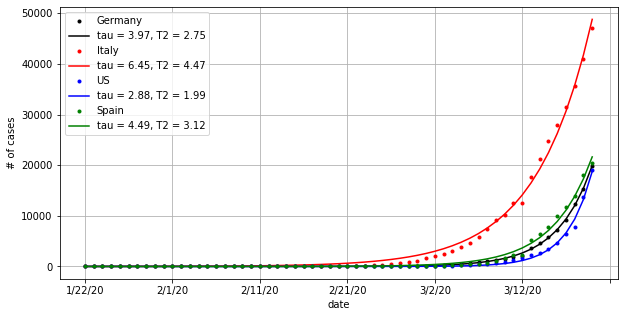

In [28]:
plt.figure(figsize=[10,5])
plot_by_country(df_confirmed, "Germany",True, False)
plot_by_country(df_confirmed, "Italy",True, False, "red")
plot_by_country(df_confirmed, "US",True, False, "blue")
plot_by_country(df_confirmed, "Spain",True, False, "green")
plt.show()

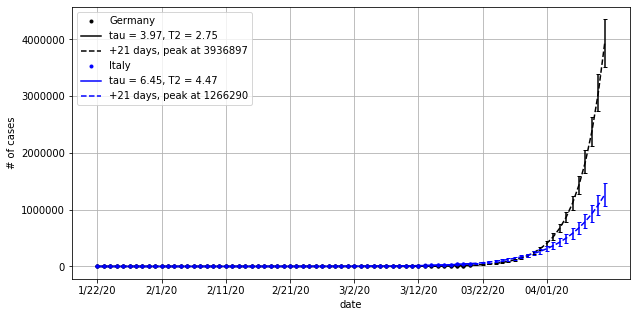

In [29]:
# Germany vs. Italy

daysplus = 21

plt.figure(figsize=[10,5])
plot_by_country(df_confirmed, "Germany",True, True)
plot_extrapolation(df_confirmed, "Germany", num_days=daysplus, confidence=True)
plot_by_country(df_confirmed, "Italy",True, True, colour="blue")
plot_extrapolation(df_confirmed, "Italy", num_days=daysplus, confidence=True, colour="blue")
plt.show()

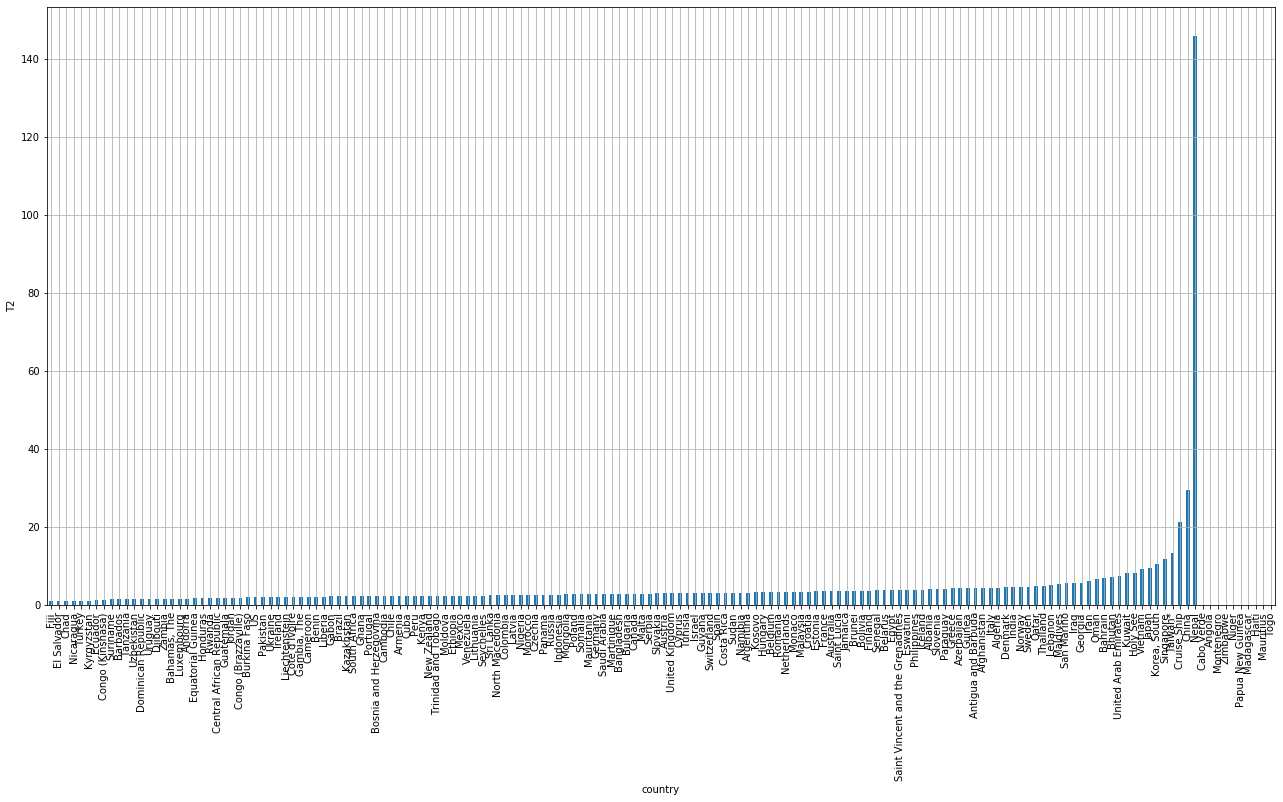

In [30]:
plot_T2s(df_confirmed)
plt.show()

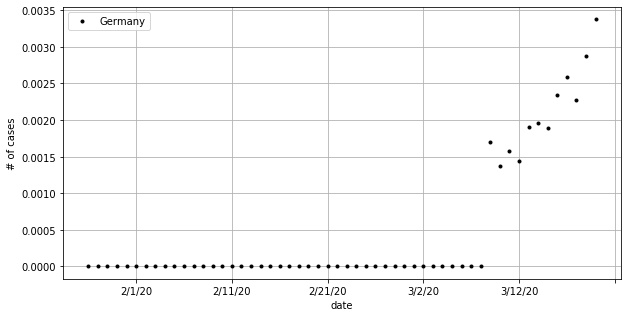

In [31]:
# case mortality rate
plt.figure(figsize=[10,5])
plot_by_country(df_case_mortality, "Germany")
# plot_by_country(df_case_mortality, "Italy", colour="blue")
plt.show()